## Pairing of Lecturers and students for the ABB Tutored dissertations

This notebook takes the spreadsheet `lecturers.xlsx` and the spreadsheet `students.xlsx` and performs the matches to find a tutor and an examinar for each student. The matchings are performed by maximizing the overlap among a set of topics. Each lecturer is assigned at least 2 topics of interes for which they can provide supervision in a tutored dissertation. Similarly the students select in order 3 topics of interest.

The matching algorithm attempts to maximize the score function

$L = \sum_{\{s,t,e\}} \langle \vec \sigma_s, \vec \phi_t \rangle + \lambda \langle \vec \sigma_s,\vec \phi_t,\vec \phi_e \rangle + \beta \langle \vec \phi_t,\vec \phi_e \rangle + \eta (\tau_t + \epsilon_e) $

Where the sum runs over all the proposed triplets ${\{s,t,e\}}$ of student/tutor/examiner (Note that there might be extra lecturers). The 5 terms of the score function, score correspondingly: 1) The alignment of interest between student and tutor, 2) The alignment of interest between student/tutor/examiner and 3) the alignment of interest between examiner/tutor (trying to assign buddies to avoid examining projects that are too far of expertise) 4) Assignment of the preferred role to the lecturer.   The function contains the following elements:

- The vectors $\vec \sigma$ contains the preferences of each student for the ordered set of topics, the vector is constructed so $\sigma_i=1$ for the top favourite topic, and $\sigma_i=-1$ for the least favourite topic ($\sum \sigma_i = 0$).
- Similarly the vectors $\vec \phi$ contain the topics of the lecturers that are encoded in the format  e.g. $\vec \phi = (0,0,f,f,0,0,0,0,f)$, where $f$ is defined so $||\vec\phi||=\sum f^2=1$.
- The constant $\lambda>0$ favours triplets with overlap of interests (Note that the triple scalar product $\langle a,b,c \rangle$ is only non-zero when there is an overlap in at least 1 category among the 3 individual).
- Finally the constant $\beta>0$ is the 'buddy' constant, maximizing the number of areas of interest between tutor/examiner.
- The weights $\tau$ (tutor) and $\epsilon$ (examiner) promote/penalize particular roles for particular lecturers. By default $\tau=\epsilon=1$ for every lecturer. These can be controlled for example to avoid a lecturer repeating a tutor role two years in a row by setting $\tau=0.1$ for that lecturer. The relevance of the weights in the final score is controlled through the parameter $\eta$
- In addition a term has been added to forbid a tutor to have more than 1 role i.e. they will supervise only 1 sutdent and will not examine any other student

The triplet list is inititialized with a greedy algorith, that assigns tutors and examiners with at least one are of interest in common. After that a simulated annealing strategy is used to improve the initial proposal, maximizing the score $L$

### Loading and formatting data

In [63]:
import pandas as pd
import numpy as np
import random as random
import matplotlib.pyplot as plt
from tqdm import tqdm

# Importing the lectuers data
file_lecturers = 'Lecturers.xlsx'
df_lecturers = pd.read_excel(file_lecturers)

# remove non-SK lecturers
df_lecturers = df_lecturers[df_lecturers['Location']=='SK']
df_lecturers.index = range(0,len(df_lecturers)) # reindex so first index is 0

#print('SK Lecturers spreadhseet read successfully:   \n',df_lecturers.head(10))

topics = ['Neurobiology','Cell and Developmental Biology',
        'Malaria and other Infectious Diseases','Cancer Biology and Immunology',
        'Bioinformatics and Computational Biology','Biophysics',
        'Plant Science','Microbiology','Synthetic Biology',
        'Structural Biology and Protein Science']


preferred_roles_diclist = {'Examiner':[0.4,1.0],'Tutor':[1.0,0.4],
                           'Extra':[0.0,0.1],'Neutral':[1.0,1.0],
                           'Overload':[0.0,0.2]} # values of ε and τ for each preferred role
N_topics = len(topics)

def encode_row_lecturer(row): # encoding topics in the vector format Φ
    econded_row = np.array([1 if row[col] == 'X' else 0 for col in topics])
    return econded_row/np.sqrt(np.sum(econded_row*econded_row)) # normalized so lecturers with less topics are not penalized in pairings


lecturers_list = [] # list with the encoded interests for each lecturer 
lecturers_prole = [] # list with the encoded preferred roles for each lecturer 
lecturers_arole =[] # list with the number of roles [tutor,examiner] assigned to each lecturer, initialized to 0
for irow, row in df_lecturers.iterrows():
    lecturer_interest = encode_row_lecturer(row)
    lecturers_list.append(lecturer_interest)
    lecturers_prole .append(preferred_roles_diclist[row['Preferred role']])
    lecturers_arole.append([0,0]) # initialize number of roles to 0 for each lecturer
    string_interests = ','.join([topics[itopic] for itopic,topic in enumerate(lecturer_interest) if topic>0])
    df_lecturers.loc[irow,'Interests'] = string_interests  
N_lecturers = len(lecturers_list)    

print('Encoding {} lecturers successfully, e.g.'.format(N_lecturers), lecturers_list[0])

# Importing the students data
# at the moment synthetically created

file_students = 'ABB Tutored Dissertation 2026_ Topic Preference Questionnaire.xlsx'
df_students = pd.read_excel(file_students)

df_students.index = range(0,len(df_students)) # reindex so first index is 0
print('Students spreadhseet read successfully:   \n',df_lecturers.head(10))

def encode_row_student(row): # encoding topics in the vector format Φ
    topics_string = row['Please rank the following project topics by dragging your most preferred topics at the top and your least preferred topics at the bottom.']
    topics_student = topics_string.split(';')
    topics_student = np.array([topics_student.index(topic) for topic in topics])
    topics_student = 2*(N_topics-1-topics_student)/(N_topics-1)-1 # normalizing student choices to [-1,1]
    return topics_student,topics_string

students_list = []
for irow, row in df_students.iterrows():
    student_interest,string_interest = encode_row_student(row)
    students_list.append(student_interest)
    print('student', student_interest)
    #string_interests = ','.join([topics[itopic] for itopic,topic in enumerate(student_interest) if topic>0])
    df_students.loc[irow,'Interests'] = string_interest 
N_students = len(students_list)    


    
#Cleaning dataFrames of unused columns
df_students = df_students[['Name','Surname','Imperial College e-mail address','Interests']]
df_lecturers = df_lecturers[['First Name','Last Name','Email address','Interests','Preferred role']]
 
print('Encoding {} students successfully, e.g. {}'.format(N_students,students_list[0]))

Encoding 73 lecturers successfully, e.g. [0.         0.         0.         0.         0.         0.57735027
 0.         0.57735027 0.         0.57735027]
Students spreadhseet read successfully:   
       Department          Last Name    First Name  \
0  Life Sciences                Ali         Maruf   
1  Life Sciences            Baldwin         Geoff   
2  Life Sciences          Bannister        Kirsty   
3  Life Sciences          Barkoulas      Michalis   
4  Life Sciences               Basu       Srinjan   
5  Life Sciences              Beeby        Morgan   
6  Life Sciences               Beis  Konstantinos   
7  Life Sciences            Bozkurt         Tolga   
8  Life Sciences              Brady      Hugh J M   
9  Life Sciences  Bregieiro Eulalio         Ana S   

                       Email address                Grade Preferred role  \
0           maruf.ali@imperial.ac.uk               Reader          Tutor   
1           g.baldwin@imperial.ac.uk            Professor       Ex

### Greedy initialization

The greedy algorithm starts assigning tutors students starting from the least popular topics from students independent of order of preference among students. Then performs the same tasks to assign examiners from the remaining lecturers. The examiners are chosen to first overlap interests with student and tutor. If not possible, then an examiner is chosen that shares at least 1 area of interest with tutor

In [64]:
# Greedy algorithm for the preliminary choice:
# First we choose the tutors as the best choice for each student ranked from rare to common
# this will ensure that we attempt to populate all the topics

free_students = list(range(N_students))
free_lecturers = list(range(N_lecturers))*2 # we duplicate the lecturers list to allow for 2 roles per lecturer
free_lecturers = sorted(free_lecturers, key = lambda x: lecturers_prole[x][0],reverse = True) # order list to put preferred examiners first

print(f"Size of initial free lecturers: {len(free_lecturers)}")

pairing = np.zeros((N_students,3),dtype=int)

topic_counts = np.sum(np.array(students_list)>0,axis=0) # count for each topic how many it recieves a positive score

print("Assigning main tutors....")

ipairing = 0

for topic in np.argsort(topic_counts):
    #print("-"*10)
    #print("Left students {}, assigning topic {}: {}\n".format(len(free_students),topic,topics[topic]))
    for student in free_students[:]:
       # print(students_list[student][topic])
        if students_list[student][topic]>0:
            for lecturer in free_lecturers[:]:
                if lecturer not in pairing[:,1]: # to avoid overloading tutors
                    if lecturers_list[lecturer][topic]>0:
                        pairing[ipairing,:] = [student,lecturer,0]
                        ipairing = ipairing + 1
                        free_students.remove(student)
                        free_lecturers.remove(lecturer)
                        #print('## student: ',df_students.iloc[student])
                        #print('\n')
                        #print('## lecturer: ',df_lecturers.iloc[lecturer])
                        #print('\n'*2)
                        break
print('Found {} suitable tutors!'.format(ipairing))
# once we ran out of topics, there might be some people without topic, we reasign those

free_pairings = np.where(pairing[:, 0] == 0)[0] # rows without a tutor


if len(free_students)>0:
    print('Assigning {} tutors that are out of the expertise'.format(N_students-len(free_students)))
    while len(free_students)>0:
        student = free_students.pop()
        searching_lecturer = True
        while (searching_lecturer):
            lecturer = free_lecturers.pop()    
            if lecturer in pairing[:,1]: # if lecturer is already mentoring, look for the next one
                free_lecturers.insert(0,lecturer)
            else:
                searching_lecturer = False        
        pairing[ipairing,:] = [student,lecturer,0]
        ipairing = ipairing + 1        

print("\nAssigning examiners ....")
ipairing = 0
free_students = list(range(N_students)) # all students are free of examiners, but lecturers is kept to avoid overloading teachers

for ipair,pair in enumerate(pairing): # for each pairing we look for a suitable examiner
    common_topics = np.nonzero((students_list[pair[0]] != 0) & (lecturers_list[pair[1]] != 0))[0] # common topics for the 3 people
    sorted_common_topics = sorted(common_topics, key = lambda x: topic_counts[x]) # to assign examiners of rarer topics
    buddy_topics = np.nonzero((students_list[pair[0]] == 0) & (lecturers_list[pair[1]] != 0))[0] # common topics among lecturers
    sorted_buddy_topics = sorted(buddy_topics, key = lambda x: topic_counts[x]) # to assign examiners of rarer topics
    sorted_topics = np.concatenate((sorted_common_topics,sorted_buddy_topics)).astype(int)
    # print("Assigning examiner to student: ",students_list[pair[0]])
    # print("with tutor: ",df_lecturers.iloc[pair[1]])
    # print("and topic list: ", [topics[t] for t in sorted_topics])
    for topic in sorted_topics:
        for lecturer in free_lecturers[:]:
            # print('evaluating topic {} /lecturer {} \n that has topics {}'.format(
                # topics[topic],df_lecturers.loc[pair[1],'Last Name'],
                # df_lecturers.loc[pair[1],'Interests']))            
            if (lecturers_list[lecturer][topic]>0 and lecturer not in pairing[:,1]): # to avoid overloading tutors
                # print('Tutor accepted!')
                pairing[ipair,2] = lecturer
                free_students.remove(pair[0])
                free_lecturers.remove(lecturer)
                break                
        else: continue # if no lecturer found then continue to next topic
        break # if lecturere found (else not triggered) then exit outer loop as well  

print('Found {} suitable examiners!'.format(N_students - len(free_students)))

print('Remaining {} examiners!'.format(len(free_lecturers)))
if len(free_students)>0:
    print('Assigning {} examiners that are out of the expertise'.format(len(free_students)))
    while len(free_students)>0:
        student = free_students.pop()
        searching_lecturer = True
        while (searching_lecturer):
            lecturer = free_lecturers.pop()    
            if lecturer in pairing[:,1]: # if lecturer is already mentoring, look for the next one
                free_lecturers.insert(0,lecturer)
            else:
                searching_lecturer = False        
        row = np.where(pairing[:, 0] == student)[0]
        pairing[row[0], 2] = lecturer  






        
print ("Finished pairing! The unassigned lecturers where: {}".format(free_lecturers))
print (pairing)        

# storing the results in a new dataframe. First we will generate dataframes for students/tutor/examiners with the information required
# then we will concatenate them in the right order

df_students_prefix = df_students.add_prefix('student ')
df_tutors_prefix = df_lecturers.add_prefix('tutor ')
df_examiners_prefix = df_lecturers.add_prefix('examiner ')
        
pairing_df = [pd.concat([df_students_prefix.iloc[i], df_tutors_prefix.iloc[j], df_examiners_prefix.iloc[k]]) for i,j,k in pairing]
pairing_df = pd.DataFrame(pairing_df).reset_index(drop=True)
pairing_df.head()
pairing_df.to_csv('preliminary_pairing.csv', index=False)

pairing_greedy = pairing[:]
free_lecturers_greedy = free_lecturers[:]


Size of initial free lecturers: 146
Assigning main tutors....
Found 40 suitable tutors!

Assigning examiners ....
Found 36 suitable examiners!
Remaining 70 examiners!
Assigning 4 examiners that are out of the expertise
Finished pairing! The unassigned lecturers where: [52, 60, 2, 4, 5, 6, 11, 14, 15, 16, 17, 19, 27, 30, 32, 34, 36, 37, 38, 43, 46, 47, 49, 55, 56, 59, 65, 67, 72, 9, 33, 53, 63, 64, 1, 9, 10, 12, 21, 25, 29, 31, 33, 39, 41, 42, 45, 48, 53, 54, 58, 63, 64, 66, 71, 3, 13, 24, 44, 50, 70, 3, 7, 13, 20, 24]
[[ 1  4  0]
 [ 6  5 61]
 [16 15  0]
 [28 19 61]
 [36 36 28]
 [37 49 35]
 [11 32 23]
 [23 37 62]
 [25 38 69]
 [31 56 23]
 [32 65 28]
 [ 5  6 25]
 [10 11 29]
 [15 27 40]
 [17 47 42]
 [27 67 54]
 [35 21 45]
 [ 0  2 44]
 [ 2 34 26]
 [ 3 59 57]
 [ 7 72 50]
 [12 10 51]
 [18 31 35]
 [ 8  1 26]
 [13 39 18]
 [19 41 70]
 [26 48 62]
 [30 71 22]
 [38 52 69]
 [ 4 55 40]
 [ 9 12 57]
 [14 58  8]
 [20 66  8]
 [21  7 30]
 [33 20 46]
 [34 60 18]
 [22 14 68]
 [24 16 22]
 [29 17 68]
 [39 43 

### Simulated annealing

The initial proposal obtained by the greedy algorithm is improve by simulated annealing

Checking greedy pairing:
Unique values in combined pairing: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Correct greedy initialization
Starting score is: 154.5319848571841, with 8 non-triplet commonalities, and 4 non-buddies


100%|██████████| 500000/500000 [01:16<00:00, 6522.61it/s]

Finished annealing!
Final Score is: 226.89704354776896, with 0 non-triplet commonalities, and 0 non-buddies


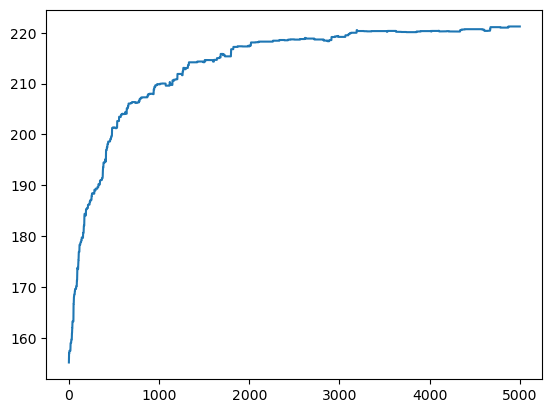

In [ ]:
T0 = 0.1 # Initial temperature cannot be very high or will erase greedy (good enough?) initialization 
Tf = 0.01 # 
niterations = 500000

m = 1
λ = 0.5
β = 1.0
η = 10.0

pairing = pairing_greedy.copy()

free_lecturers = free_lecturers_greedy.copy()


combined_pairing = np.concatenate((pairing[:, 1], pairing[:, 2],free_lecturers))
# Check for correct structure of greedy pairing
print("Checking greedy pairing:")
# Check that there were no new duplicates created
vals, counts = np.unique(combined_pairing, return_counts=True)
print ("Unique values in combined pairing:", vals, counts)
if not np.all(counts == 2):
    print("Error: A lecturer appears more than twice in the pairing!")
# Check that tutors are not overloaded
elif (np.unique(pairing[:,1]).size != pairing[:,1].size):
    print("Error: A tutor appears more than once in the pairing!")
    print(pairing[:,1])
elif (np.intersect1d(pairing[:,1],pairing[:,2]).size != 0):
    print("Error: A tutor appears to also be examining!")
else:
    print("Correct greedy initialization")

def score(student,tutor,examiner): # score of a specific triplet, returns 3 scores (score1, score2, score3)
    # score1: function to maximize for perfect pairing -> L
    # score2: number of topics share among all individuals in the triplet
    # score3: number of topics common between examiner/tutor
    σS = students_list[student]
    φT = lecturers_list[tutor]
    φE = lecturers_list[examiner]
    τ = lecturers_prole[tutor][0]
    ε = lecturers_prole[examiner][1]
    #print("Proposed pairing: ",σS,φT,φE)
    #print("Products: ",np.sum(σS*φT),np.sum(σS*φT*φE) )
    #print("scores: ",np.sum(σS*φT*(1 + λ*φE)) + np.sum(β*φT*φE) + η*(τ+ε),  np.sum((σS>0)*φT*φE), np.sum(φT*φE))
    return np.sum(σS*φT*(1 + λ*φE)) + np.sum(β*φT*φE) + η*(τ+ε),  np.sum((σS>0)*φT*φE), np.sum(φT*φE) 

scores = np.array([score(s,t,e) for s,t,e in pairing],dtype=float) # scores of the initial pairings
# print("Initial Scores:", scores)

# pairings with lower scores will be prioritize to change. This can be done by introducing weights based on the score
rank_scores = len(scores) - np.argsort(np.argsort(scores[:,0])) # rank of scores
weights = 1 + (rank_scores -1)*(10-1)/(len(rank_scores)-1) # weight scores from 1 to 10
weights = weights / np.sum(weights) # normalize the weights
# print('weights =',weights)

p0 = 0.1
def update_weights(weights):
    rank_scores = len(scores) - np.argsort(np.argsort(scores[:,0])) # rank of scores
    weights = 1 + (rank_scores -1)*(10-1)/(len(rank_scores)-1) # weight scores from 1 to 10
    weights = weights / np.sum(weights) # normalize the weights
    

print("Starting score is: {}, with {} non-triplet commonalities, and {} non-buddies".format(
    np.sum(scores[:,0]),np.sum(scores[:,1] == 0), np.sum(scores[:,2] == 0)))        


def external_annealing(pairing,weights,scores,free_lecturers): 
    # attempt to introduce one of the non-used examiners
    searching_valid_external = True
    
    while searching_valid_external:            
        new_lecturer = np.random.choice(free_lecturers)
        irole = 1+np.random.choice(range(2)) # examiner or tutor?
        
        # first we will check the conditions for a valid pairing (not overloading tutors)    
        if new_lecturer in pairing[:,1]: # if the new lecturer is not already a tutor
            searching_valid_external = True
        elif new_lecturer in pairing[:,2] and irole ==1: # if the lecturer is already an examiner, and is proposed to be a tutor  
            searching_valid_external = True
        else: 
            searching_valid_external = False # acceptable external
    
    ipairing = np.random.choice(range(N_students),p=weights) # target pairing
    busy_lecturer = pairing[ipairing,irole]
        
    L_before = score(* (pairing[ipairing]))[0]
    
    new_pairing = (pairing[ipairing]).copy()
    new_pairing[irole] = new_lecturer
    
    scores_after = score(*new_pairing)
    L_after = scores_after[0]
    
    
    if (L_after>L_before or np.exp((L_after-L_before)/T) > random.random()): # accept swap
        pairing[ipairing] = new_pairing
        free_lecturers.remove(new_lecturer)
        free_lecturers.append(busy_lecturer)
        scores[ipairing] = scores_after
        update_weights(weights)
        

def swap_annealing(pairing,weights,scores):
    # choose two lecturers to swap. First lecturers is chosed from a student with a probability inversely proportional to their score
    
    ipairing1 = np.random.choice(range(N_students), p=weights)
    ipairing2 = np.random.choice(range(N_students))

    
    if (ipairing1 != ipairing2): # if different students propose a swap of examiners or tutors (this do not affect tutor overload)

        pairing1 = (pairing[ipairing1]).copy()
        pairing2 = (pairing[ipairing2]).copy()

        L_before = score(*pairing1)[0] + score(*pairing2)[0]

        # choose a kind of exchange at random:
        irole = 1+np.random.choice(range(2)) # examiner or tutor?
        #idx2 = 1+np.random.choice(range(2)) # examiner or tutor?
        # print("\n idxs:",idx1,idx2)
        # print("ipairings:",ipairing1,ipairing2)
        # print("original pairings:", pairing1, pairing2)

        pairing2[irole], pairing1[irole] = pairing1[irole], pairing2[irole]
    
        # print("proposed pairings:", pairing1, pairing2)
    
        L_after = score(*pairing1)[0] + score(*pairing2)[0]
           
        if (L_after>L_before or np.exp((L_after-L_before)/T) > random.random()): # accept swap
            pairing[ipairing1] = pairing1[:]
            pairing[ipairing2] = pairing2[:]
            scores[ipairing1] = score(*pairing1)
            scores[ipairing2] = score(*pairing2)
            update_weights(weights)

    
    else: # if same student chosen then getting examiner/tutor swapped if tutor is not overloaded
        
        pairing1 = (pairing[ipairing1]).copy()
        proposed_tutor = pairing1[2]
        other_examiners = np.delete(pairing[:, 2], ipairing1)
        
        if (proposed_tutor not in pairing[:,1]) and (proposed_tutor not in other_examiners): # if the selected tutor is not already an examiner
                        
            L_before = scores[ipairing1,0]
            pairing1[1], pairing1[2] = pairing1[2], pairing1[1]
            L_after = score(*pairing1)[0]

            if (L_after>L_before or np.exp((L_after-L_before)/T) > random.random()): # accept swap
                pairing[ipairing1] = pairing1[:]
                scores[ipairing1] = score(*pairing1)
                update_weights(weights)

        

    combined_pairing = np.concatenate((pairing[:, 1], pairing[:, 2],free_lecturers))
    # Check that there were no new duplicates created
    vals, counts = np.unique(combined_pairing, return_counts=True)
    if not np.all(counts == 2):
        print("Error: A lecturer appears more than twice in the pairing!")
    # Check that tutors are not overloaded
    elif (np.unique(pairing[:,1]).size != pairing[:,1].size):
        print("Error: A tutor appears more than once in the pairing!")
        print(pairing[:,1])
    elif (np.intersect1d(pairing[:,1],pairing[:,2]).size != 0):
        print("Error: A tutor appears to also be examining!")
    
        
# # main annealing loop

T=T0
dT = (Tf/T0)**(1/niterations)
historyL = []


batch = niterations//100
for i in tqdm(range(niterations)):
    swap_annealing(pairing,weights,scores)
    external_annealing(pairing,weights,scores,free_lecturers)        
    T = T * dT
    if i//batch == 0:
        historyL.append(np.sum(scores[:,0]))
    
plt.plot(historyL)


print("Finished annealing!")
print("Final Score is: {}, with {} non-triplet commonalities, and {} non-buddies".format(np.sum(scores[:,0]),np.sum(scores[:,1] == 0), np.sum(scores[:,2] == 0)))        
        
        
pairing_df = [pd.concat([df_students_prefix.iloc[i], df_tutors_prefix.iloc[j], df_examiners_prefix.iloc[k]]) for i,j,k in pairing]
pairing_df = pd.DataFrame(pairing_df).reset_index(drop=True)
pairing_df['Score1'] = scores[:,0]
pairing_df['Score2'] = scores[:,1]
pairing_df['Score3'] = scores[:,2]
pairing_df.to_csv('annealed_pairing.csv', index=False)

        
    
    

In [7]:
free_lecturers
df_tutors_prefix[]

[50, 12, 18, 23, 30]

In [8]:
 [df_tutors_prefix.iloc[j] for j in free_lecturers]

[tutor First Name                                                    Ruben
 tutor Last Name                                            Perez-Carrasco
 tutor Email address                       r.perez-carrasco@imperial.ac.uk
 tutor Interests         Cell and Developmental Biology,Bioinformatics ...
 tutor Preferred role                                                Extra
 Name: 50, dtype: object,
 tutor First Name                                                 Laurence
 tutor Last Name                                                    Bugeon
 tutor Email address                               l.bugeon@imperial.ac.uk
 tutor Interests         Cell and Developmental Biology,Cancer Biology ...
 tutor Preferred role                                                Extra
 Name: 12, dtype: object,
 tutor First Name                               Ste
 tutor Last Name                               Cook
 tutor Email address     steven.cook@imperial.ac.uk
 tutor Interests         Plant Science,Mic